In [1]:
import pandas as pd
import numpy as np #之后需要用到
import seaborn as sns
from datetime import datetime,timedelta
import matplotlib as mpl #设置环境变量
import matplotlib.pyplot as plt #绘图专用
mpl.rcParams['font.sans-serif'] = ['FangSong']
mpl.rcParams['axes.unicode_minus']=False

In [2]:
def readTsvDates(base_dir, app_name, date_from, date_to):
    date_from = datetime.strptime(date_from, '%Y-%m-%d')
    date_to = datetime.strptime(date_to, '%Y-%m-%d')
    result = []
    for one in range(0, (date_to-date_from).days + 1):
        result.append(pd.read_csv('./data' + base_dir + '/' + app_name + '/'+ (date_from +  timedelta(days=one)).strftime("%Y-%m-%d")+ '/data.tsv', sep='\t' ))
    return pd.concat(result)

In [3]:
dau = readTsvDates('/sample-data/section8/daily/dau', 'game-01', '2013-05-01', '2013-10-31')
dpu = readTsvDates('/sample-data/section8/daily/dpu', 'game-01', '2013-05-01', '2013-10-31')
action = readTsvDates('/sample-data/section8/daily/action', 'game-01', '2013-10-31', '2013-10-31')

In [4]:
dau_dpu = dau.merge(dpu[['log_date', 'user_id', 'payment']], how='left', on=['log_date', 'user_id'])

In [5]:
dau_dpu['payment'].fillna(0, inplace=True)

In [6]:
dau_dpu.head()

,log_date,app_name,user_id,payment
0,2013-05-01,game-01,608801,0.0
1,2013-05-01,game-01,712453,0.0
2,2013-05-01,game-01,776853,0.0
3,2013-05-01,game-01,823486,0.0
4,2013-05-01,game-01,113600,0.0


In [7]:
dau_dpu['ispayment'] = dau_dpu.apply(lambda v: 1 if v.payment else 0, axis=1)

In [8]:
dau_dpu['log_month'] = dau_dpu.apply(lambda v: v.log_date[:7], axis=1)

In [9]:
access_days = dau_dpu.groupby(['log_month', 'user_id']).count().loc[:,['app_name']].reset_index().rename(columns={'app_name': 'access_days'})

In [10]:
payment = dau_dpu.groupby(['log_month', 'user_id']).sum().loc[:,['payment']].reset_index()

In [11]:
mau = access_days.merge(payment, how='left', on=['log_month','user_id'])

In [12]:
mau.head()

,log_month,user_id,access_days,payment
0,2013-05,65,1,0.0
1,2013-05,115,1,0.0
2,2013-05,194,1,0.0
3,2013-05,426,4,0.0
4,2013-05,539,1,0.0


In [13]:
action.head()

,log_date,app_name,user_id,A1,A2,A3,A4,A5,A6,A7,...,A45,A46,A47,A48,A49,A50,A51,A52,A53,A54
0,2013-10-31,game-01,654133,0,0,0,0,0,0,0,...,0,0,380,25655,0,0,0,0,0.0,46
1,2013-10-31,game-01,425530,0,0,0,0,10,1,233,...,19,20,180543,347,36,22,4,0,0.0,71
2,2013-10-31,game-01,709596,0,0,0,0,0,0,0,...,0,0,416,24817,0,0,0,0,0.0,2
3,2013-10-31,game-01,525047,0,2,0,0,9,0,0,...,22,22,35200,6412,21,0,0,0,0.0,109
4,2013-10-31,game-01,796908,0,0,0,0,0,0,0,...,29,29,388,25444,1,0,0,0,0.0,64


In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
y_kmeans = kmeans.fit_predict(action[['A47','A47']])
y_kmeans

array([0, 2, 0, ..., 0, 0, 1])

每个分类的人数

In [15]:
pd.Series(y_kmeans).value_counts()

0    2096
1     479
2      78
dtype: int64

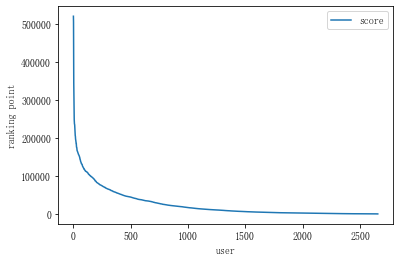

In [16]:
score = action.A47.sort_values(ascending=False)
plt.plot( range(1, len(action.index)+1),score, label="score")
plt.xlabel('user')
plt.ylabel('ranking point')
plt.legend(loc='best')
plt.show()

截取排名靠前的用户

In [17]:
action['actived'] = y_kmeans

选择活跃用户actived标识为1，2

In [18]:
actived = action[action['actived'] != 0 ]

In [19]:
actived

,log_date,app_name,user_id,A1,A2,A3,A4,A5,A6,A7,...,A46,A47,A48,A49,A50,A51,A52,A53,A54,actived
1,2013-10-31,game-01,425530,0,0,0,0,10,1,233,...,20,180543,347,36,22,4,0,0.0,71,2
5,2013-10-31,game-01,776120,0,0,0,0,9,0,0,...,38,142214,684,37,15,0,0,0.0,312,2
7,2013-10-31,game-01,276197,0,0,0,0,7,0,58,...,15,54602,4226,15,0,8,0,0.0,95,1
8,2013-10-31,game-01,221572,0,0,0,0,1,0,0,...,24,39891,5792,4,0,0,0,0.0,21,1
9,2013-10-31,game-01,692433,0,0,0,0,6,0,0,...,28,50706,4549,16,8,0,0,0.0,154,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,2013-10-31,game-01,850278,0,0,0,0,8,0,0,...,13,123330,1018,30,17,0,0,0.0,103,1
2642,2013-10-31,game-01,948790,0,0,0,0,5,0,0,...,13,40507,5714,8,0,0,0,0.0,45,1
2644,2013-10-31,game-01,180607,0,0,0,0,5,0,0,...,20,45632,5070,16,1,0,0,0.0,153,1
2645,2013-10-31,game-01,355353,0,0,0,0,7,0,0,...,27,63681,3536,17,3,0,0,0.0,80,1


In [99]:
actived_new = actived.loc[:,'A2':'A54']

In [78]:
actived_new.head()

,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,...,A45,A46,A47,A48,A49,A50,A51,A52,A53,A54
1,0,0,0,10,1,233,58.25,288,230,19,...,19,20,180543,347,36,22,4,0,0.0,71
5,0,0,0,9,0,0,0.00,325,195,38,...,19,38,142214,684,37,15,0,0,0.0,312
7,0,0,0,7,0,58,7.25,150,100,15,...,15,15,54602,4226,15,0,8,0,0.0,95
8,0,0,0,1,0,0,0.00,40,14,0,...,24,24,39891,5792,4,0,0,0,0.0,21
9,0,0,0,6,0,0,0.00,102,95,0,...,15,28,50706,4549,16,8,0,0,0.0,154


In [ ]:
删除0值占比90%以上的列

In [94]:
drop_columns = []
for i in range(2, 54):
    column = 'A'+str(i)
    n = actived_new[actived_new[column] == 0][column].count()
    if n/557 > 0.90:
        drop_columns.append(column)
print(drop_columns, len(drop_columns))

['A2', 'A3', 'A4', 'A19', 'A21', 'A22', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42'] 22


In [101]:
column = 'A'+str(2)
n = actived_new[actived_new[column] == 0][column].count()
n/557

0.926391382405745

In [102]:
actived_new = actived_new.drop(drop_columns, axis=1)

In [92]:
actived_new

,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,...,A45,A46,A47,A48,A49,A50,A51,A52,A53,A54
1,10,1,233,58.25,288,230,19,2,19,13,...,19,20,180543,347,36,22,4,0,0.0,71
5,9,0,0,0.00,325,195,38,8,19,10,...,19,38,142214,684,37,15,0,0,0.0,312
7,7,0,58,7.25,150,100,15,3,11,5,...,15,15,54602,4226,15,0,8,0,0.0,95
8,1,0,0,0.00,40,14,0,0,3,0,...,24,24,39891,5792,4,0,0,0,0.0,21
9,6,0,0,0.00,102,95,0,0,2,2,...,15,28,50706,4549,16,8,0,0,0.0,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,8,0,0,0.00,247,200,13,5,26,9,...,12,13,123330,1018,30,17,0,0,0.0,103
2642,5,0,0,0.00,59,30,0,0,9,3,...,13,13,40507,5714,8,0,0,0,0.0,45
2644,5,0,0,0.00,157,190,20,2,6,4,...,19,20,45632,5070,16,1,0,0,0.0,153
2645,7,0,0,0.00,158,190,27,5,5,6,...,27,27,63681,3536,17,3,0,0,0.0,80


In [103]:
corr_matrix = actived_new.corr()

In [104]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,...,A45,A46,A47,A48,A49,A50,A51,A52,A53,A54
A5,NaN,0.178833,0.219395,0.186124,0.721625,0.476032,0.271252,0.340187,0.348730,0.581038,...,0.206970,0.263173,0.437359,-0.509531,0.748432,0.529860,0.128257,0.035550,0.043092,0.247926
A6,NaN,NaN,0.371360,0.242025,0.233493,0.492319,0.034569,0.091227,0.039213,0.139633,...,0.084986,0.088166,0.184251,-0.176314,0.234867,0.144136,0.357951,0.165791,0.152589,-0.070820
A7,NaN,NaN,NaN,0.803161,0.242129,0.354588,0.001125,0.059863,0.062767,0.197402,...,0.101648,0.091934,0.186181,-0.172895,0.239601,0.126870,0.581271,0.120955,0.136693,-0.070159
A8,NaN,NaN,NaN,NaN,0.165923,0.243065,0.020008,0.044852,0.024167,0.150229,...,0.094891,0.094585,0.186590,-0.141561,0.162515,0.080251,0.238557,0.092873,0.127487,-0.079725
A9,NaN,NaN,NaN,NaN,NaN,0.671752,0.337224,0.489015,0.385453,0.735786,...,0.244763,0.315184,0.566437,-0.646578,0.984790,0.509102,0.182117,0.113329,0.110910,0.332789
A10,NaN,NaN,NaN,NaN,NaN,NaN,0.229126,0.412885,0.218385,0.446975,...,0.189892,0.241910,0.341044,-0.412132,0.655660,0.305706,0.348481,0.177964,0.179723,0.154317
A11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.653904,0.251858,0.417609,...,0.520274,0.593106,0.242843,-0.363719,0.336443,0.214648,-0.030735,-0.078313,-0.083898,0.434948
A12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.197365,0.518654,...,0.159433,0.230677,0.283725,-0.392957,0.471417,0.218727,0.055016,-0.029540,-0.029286,0.245967
A13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.594665,...,0.162273,0.215363,0.466796,-0.400685,0.427445,0.433830,0.023451,-0.044329,-0.047193,0.351182
A14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.232256,0.301614,0.561367,-0.550008,0.761723,0.499234,0.088853,-0.007395,-0.000582,0.314533


In [107]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
actived_new.drop(to_drop,axis = 1, inplace=True)

In [108]:
actived_new

,A5,A6,A7,A10,A11,A12,A13,A16,A20,A25,A45,A47,A48,A50,A51,A52,A54
1,10,1,233,230,19,2,19,28,0,0.92857,19,180543,347,22,4,0,71
5,9,0,0,195,38,8,19,25,0,0.92424,19,142214,684,15,0,0,312
7,7,0,58,100,15,3,11,19,0,0.83333,15,54602,4226,0,8,0,95
8,1,0,0,14,0,0,3,13,0,0.90909,24,39891,5792,0,0,0,21
9,6,0,0,95,0,0,2,12,0,1.00000,15,50706,4549,8,0,0,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,8,0,0,200,13,5,26,27,0,0.85135,12,123330,1018,17,0,0,103
2642,5,0,0,30,0,0,9,8,0,0.88235,13,40507,5714,0,0,0,45
2644,5,0,0,190,20,2,6,18,0,0.82353,19,45632,5070,1,0,0,153
2645,7,0,0,190,27,5,5,22,0,0.96296,27,63681,3536,3,0,0,80


In [109]:
from sklearn.decomposition import PCA
pca = PCA()
pca_result = pca.fit_transform(actived_new)

In [110]:
pca_result.shape

(557, 17)